In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, copy, os, shutil
from tqdm.notebook import tqdm
import seaborn as sns
from importlib import reload
import copy, time
from IPython.display import clear_output

# our helper functions for the gridworlds
import GridWorldHelpers as gwh

In [2]:
# initializing our environments + corresponding colors
d = 8 # dimension of our 
gw0, gw1, gw2 = gwh.build_grids(d=8, baseline_penalty = -1, water_penalty = -10, end_reward = 100)
gw0_colors = gwh.make_gw_colors(gw0)
gw1_colors = gwh.make_gw_colors(gw1)
gw2_colors = gwh.make_gw_colors(gw2)

# store quick-access indices for the environment
environments = {
                0: [gw0, gw0_colors], # baseline
                1: [gw1, gw2_colors], # non-flooding
                2: [gw2, gw2_colors] # flooding
               }

# global environment parameters 
p_switch = 0.0 # 0.25 # flooding Markov chain parameter
p_wind_i = 0.0 # 0.25 # up-down wind frequency
p_wind_j = 0.0 # 0.25 # left-right wind frequency

# global missing-data parameters
thetas = np.array([0.0, 0.0, 0.0]) # np.array([0.25, 0.25, 0.25])
thetas_in = np.array([0.50, 0.50, 0.50])
thetas_out = np.array([0.1, 0.1, 0.1])
theta_dict = {0 : np.array([0.1, 0.1, 0.1]), 
              1 : np.array([0.2, 0.2, 0.2]), 
              2 : np.array([0.3, 0.3, 0.3])}
i_range, j_range = (0, 2), (5, 7)

# what is our starting "current environment"
ce = 1

# which environments are we flipping through?
indices = np.array([1, 2]) # the two to be flipping between, if any. If just one, make first element

In [3]:
# set a seed
np.random.seed(858)

# make sure we are refreshing our helper functions
reload(gwh)

##### SIMULATION SETTINGS
max_iters = 20000

# which baseline imputing setting are we using? (note in random_action, do NOT update Q-matrix!)
impute_method_settings = ["last_fobs", "random_action", "missing_state"]
impute_method = impute_method_settings[1]

# which missing-data setup are we using for environment?
env_missing_settings = ["MCAR", "Mcolor", "Mfog"]
env_missing = env_missing_settings[0]

# for epsilon greedy, alpha, gamma in Q-learning
epsilon = 0.05
alpha, gamma = 0.1, 0.1 # we'll tune alpha + gamma

##### INITIALIZING START OF SIMULATIONS + DATA STRUCTURES

# initialize our Q matrix: {((i, j, color), (a1, a2))}
Q = gwh.init_Q(d, init_value=0.0)
action_descs = gwh.load_actions()
actions = list(action_descs.keys())

# counter of how many episodes we've hit
finished_episodes = 0

# initialize our starting environment + corresponding colors
env, env_colors = environments[ce][0], environments[ce][1]

# initialize our true initial state to be the bottom left corner. Assume fully-observed initial state
true_state = (d-1, 0, env_colors[d-1, 0])
pobs_state, impu_state = true_state, true_state

# things we want to store: rewards, time per iteration, last fully-observed state, Qmatrices every X steps.
rewards, times, path_lengths, last_fobs_state = [], [], [], copy.deepcopy(true_state)

##### PROCEED FOR EACH TIMESTEP

# initialize our path_length
path_length = 0

# for each timestep ...
for t_step in range(max_iters):
    
    # start our timer
    start_time = time.time()
    
    ##### "choose action A from S using policy-derived from Q (e.g., \epsilon-greedy)"
    
    # do we have any missing state values?
    if np.any(np.isnan(pobs_state).mean()):
        
        # deal with it accordingly to get imputed actions
        if impute_method == "last_fobs":
            action = gwh.select_action(last_fobs_state, Q, epsilon)
        elif impute_method == "random_action":
            action = actions[np.random.choice(a=len(actions))]
        elif impute_method == "missing_state":
            action = gwh.select_action("missing", Q, epsilon)                         #TODO: need to encode state that can have "missing" as a value
        else:
            raise Exception("impute_method choice is not currently supported.")
        
    # if not, update our last_fobs_state + select an action accordingly
    else:
        
        # select our action using standard epsilon-greedy on Q
        action = gwh.select_action(pobs_state, Q, epsilon)
    
    ##### "Take action A, observe R, S'" - BASED ON TRUE STATE, OF COURSE!
    
    # toggle our environment potentially!
    env, env_colors = environments[gwh.get_environment(ce, p_switch, indices)]
    
    # figure out what our new state is, which tells us our reward
    new_true_state = gwh.true_move(true_state, action, env, env_colors, p_wind_i, p_wind_j)
    reward = env[int(new_true_state[0]), int(new_true_state[1])]
    rewards.append(reward)
    
    # simulate our partially-observed mechanism.
    if env_missing == "MCAR":
        new_pobs_state = gwh.MCAR(new_true_state, thetas)
    elif env_missing == "Mcolor":
        new_pobs_state = gwh.Mcolor(new_true_state, theta_dict)
    elif env_missing == "Mfog":
        new_pobs_state = gwh.Mfog(new_true_state, i_range, j_range, thetas_in, thetas_out)
    else:
        raise Exception("The given env_missing mode is not supported.")
        
    # make our imputation for the new_pobs_state, if not everything is observed.
    if np.any(np.isnan(np.array(new_pobs_state)).mean()):
    
        if impute_method == "last_fobs":
            new_impu_state = copy.deepcopy(last_fobs_state)
        elif impute_method == "random_action":
            new_impu_state = None # we're not imputing any states!
        elif impute_method == "missing_state":
            new_impu_state = "missing"
        else:
            raise Exception("impute_method choice is not currently supported.")
    
    # if nothing is missing, just set new_impu_state equal to the new_pobs_state
    else:
        
        # just make a deepcopy!
        new_impu_state = copy.deepcopy(new_pobs_state)
    
    # update our Q functions if permitted
    
    #TODO: will need to feed alpha = alpha/K for the multiple imputation stuff 
    
    if impute_method != "random_action":
        Q = gwh.update_Q(Q, impu_state, action, reward, new_impu_state, alpha, gamma)
    elif ~np.any(np.isnan(new_pobs_state)):
        if ~np.any(np.isnan(pobs_state)):
            Q = gwh.update_Q(Q, pobs_state, action, reward, new_pobs_state, alpha, gamma)
        
    # check whether our last_fobs_state can be updated
    if ~np.any(np.isnan(pobs_state).mean()):
        last_fobs_state = copy.deepcopy(pobs_state)
    
    # update variable names for true_state, pobs_state, impu_state
    true_state = copy.deepcopy(new_true_state)
    pobs_state = copy.deepcopy(new_pobs_state)
    impu_state = copy.deepcopy(new_impu_state)
    
    # end our timer + record time elapsed
    end_time = time.time()
    times.append(end_time - start_time)
    
    # update our counter
    path_length += 1
    
    # also see if we hit the terminal state
    if (true_state[0] == 6) and (true_state[1] == 7):
        finished_episodes += 1
        
        # record our path_length
        path_lengths.append(path_length)
        path_length = 0
    
    # status update?
    if (t_step+1) % 5 == 0:
        clear_output(wait=True)
        print(f"Timestep: {t_step+1}, Cum. Mean Reward: {np.round(np.mean(rewards), 3)}, Finished Episodes: {finished_episodes}, Past 20 Mean Path Length: {np.round(np.mean(path_lengths[-20:]), 3)}")

Timestep: 20000, Cum. Mean Reward: 2.628, Finished Episodes: 733, Past 20 Mean Path Length: 8.35


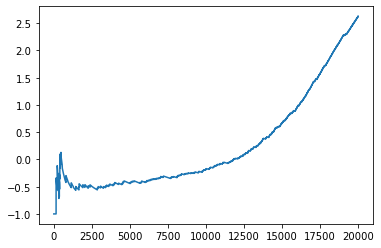

In [195]:
plt.plot(np.cumsum(rewards) / (np.arange(len(rewards)) + 1))